In [1]:
import random
import time
import pickle
import sys
import json
import re
import string
import collections
import codecs
from io import BytesIO

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mpld3

from sklearn import feature_extraction

import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

import pyLDAvis
import pyLDAvis.gensim

import nltk
from nltk.corpus import stopwords
from nltk.tag.sequential import ClassifierBasedTagger
#from nltk.stem.wordnet import WordNetLemmatizer
#from nltk.tokenize import word_tokenize

#sudo apt-get install python-dev graphviz libgraphviz-dev pkg-config
#sudo pip install pygraphviz
import pygraphviz 
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

pd.options.mode.chained_assignment = None  # default='warn'

## 1 - Fragebogen

#### Reading fragebogen information

In [2]:
fb_original = pd.read_pickle('./fb_original.pickle')

In [3]:
fb_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109 entries, 1 to 109
Data columns (total 5 columns):
titel             109 non-null object
number            109 non-null object
headwords         109 non-null object
series            109 non-null object
headwords_list    109 non-null object
dtypes: object(5)
memory usage: 5.1+ KB


In [4]:
fb_original.head(10)

titel number  \
nummer                                                             
1                                  Fragebogen 1: Kopf (1)      1   
2                        Fragebogen 2: Die Osterwoche (1)      2   
3                        Fragebogen 3: Die Osterwoche (2)      3   
4                                  Fragebogen 4: Kopf (2)      4   
5       Fragebogen 5: Zeit zwischen Ostern und Fronlei...      5   
6         Fragebogen 6: Menschl. Haar und Bart (= Kopf 3)      6   
7                              Fragebogen 7: Hochzeit (1)      7   
8                              Fragebogen 8: Hochzeit (2)      8   
9                              Fragebogen 9: Hochzeit (3)      9   
10                            Fragebogen 10: Hochzeit (4)     10   

                                    headwords      series  \
nummer                                                      
1                                        Kopf         (1)   
2                              Die Osterwoche         (1)   
3                              Die Osterwoche         (2)   
4                                        Kopf         (2)   
5       Zeit zwischen Ostern und Fronleichnam               
6                      Menschl. Haar und Bart  (= Kopf 3)   
7                                    Hochzeit         (1)   
8                                    Hochzeit         (2)   
9                                    Hochzeit         (3)   
10                                   Hochzeit         (4)   

                      headwords_list  
nummer                                
1                             [kopf]  
2                       [osterwoche]  
3                       [osterwoche]  
4                             [kopf]  
5       [fronleichnam, zeit, ostern]  
6              [haar, bart, menschl]  
7                         [hochzeit]  
8                         [hochzeit]  
9                         [hochzeit]  
10                        [hochzeit]

In [5]:
#https://matplotlib.org/2.0.2/api/colors_api.html

G = nx.Graph()

for concept_list in fb_original.headwords_list:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in fb_original.number:
    G.add_node(questionnaire, color='yellow')
    
for idn in fb_original.index:
    for concept in fb_original.loc[idn, 'headwords_list']:
        G.add_edge(concept, fb_original.loc[idn, 'number'], length = 10)

In [6]:
#print(G.nodes)
print(G.edges)

[('kopf', '1'), ('kopf', '4'), ('osterwoche', '2'), ('osterwoche', '3'), ('fronleichnam', '5'), ('zeit', '5'), ('zeit', '54'), ('zeit', '68'), ('zeit', '72'), ('ostern', '5'), ('ostern', '72'), ('haar', '6'), ('bart', '6'), ('menschl', '6'), ('hochzeit', '7'), ('hochzeit', '8'), ('hochzeit', '9'), ('hochzeit', '10'), ('hochzeit', '11'), ('nase', '12'), ('ohr', '12'), ('auge', '13'), ('besiedelung', '14'), ('besiedelung', '15'), ('flur', '14'), ('flur', '15'), ('feld', '16'), ('feld', '17'), ('feld', '18'), ('feld', '19'), ('feldbestellung', '16'), ('feldbestellung', '17'), ('feldbestellung', '18'), ('feldbestellung', '19'), ('körper', '20'), ('körper', '21'), ('körper', '22'), ('körper', '23'), ('körperteil', '24'), ('körperteil', '77'), ('körperteil', '78'), ('hautkrankheit', '25'), ('hautkrankheit', '26'), ('hautkrankheit', '27'), ('brotbacken', '28'), ('brotbacken', '29'), ('brotbacken', '30'), ('weißgebäck', '31'), ('gliedmaß', '32'), ('arm', '32'), ('arm', '33'), ('hand', '34'), (

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


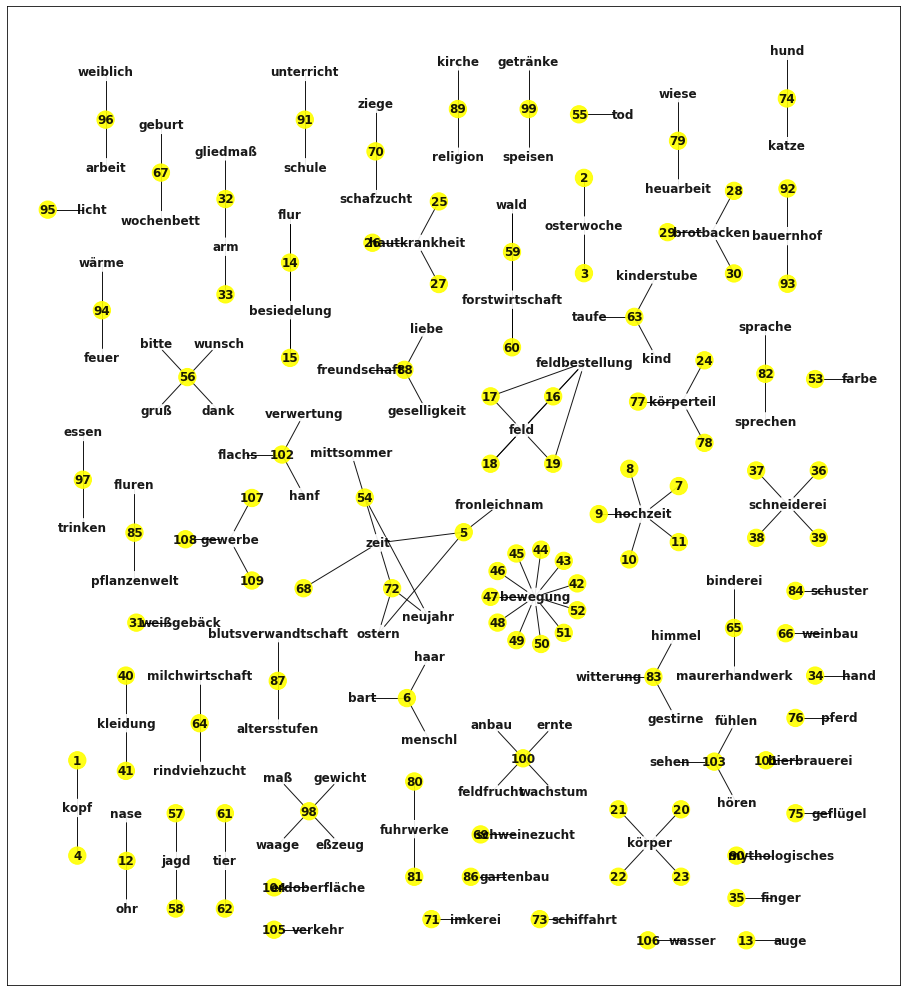

In [7]:
#https://stackoverflow.com/questions/48240021/alter-edge-length-and-cluster-spacing-in-networkx-matplotlib-force-graph
#if Win: https://graphviz.gitlab.io/_pages/Download/Download_windows.html
# https://stackoverflow.com/questions/4571067/installing-pygraphviz-on-windows?rq=1
#if Anaconda: conda install graphviz pygraphviz -c alubbock
#pip install --global-option=build_ext --global-option="-IC:\Program Files\<path>\Graphviz2.38\include" --global-option="-LC:\Program Files\Graphviz2.38\lib\release\lib" pygraphviz

plt.figure(figsize=(16,18))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 #width=5,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 font_weight='bold', 
                 #font_color='white',
                 )


plt.show()

## 2 - Frage

#### Reading frage information

In [8]:
frage = pd.read_pickle('./frage.pickle')

In [9]:
frage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16738 entries, 0 to 16743
Data columns (total 7 columns):
fragebogen_id      16738 non-null int64
nummer             16738 non-null object
original_frage     16738 non-null object
main_theme         16738 non-null object
question_words     16738 non-null object
semantic_words     16738 non-null object
syntactic_words    16738 non-null object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


In [10]:
frage.head(10)

fragebogen_id nummer                                     original_frage  \
0              1     A1           Kopf: Kopf, Haupt; auch scherzh./übertr.   
1              1     A2  Kopf: Kopf/Haupt (in urspr. Bed.) in Vergl./Ra...   
2              1     A3  Kopf: Kopf/Haupt (übertr.) in Vergl./Ra. (das ...   
3              1     A4  Kopf: schöner, ebenmäßig gebauter Kopf (Christ...   
4              1    A4a                Kopf: häßlicher, unebenmäßiger Kopf   
5              1     A5                      Kopf: großer Kopf; großkopfig   
6              1    A5a                                   Kopf: Wasserkopf   
7              1     A6                                 Kopf: kleiner Kopf   
8              1     A7                       Kopf: oben zugespitzter Kopf   
9              1     A8                                  Kopf: langer Kopf   

  main_theme                                     question_words  \
0     [kopf]              [übertragen, haupt, scherzhaft, kopf]   
1     [kopf]  [zerspringen, ursprünglich, möchten, redensart...   
2     [kopf]  [übertragen, redensarten, vergleich, verdrehen...   
3     [kopf]  [tituskopf, schön, gebaut, christuskopf, ebenm...   
4     [kopf]                       [unebenmäßig, häßlich, kopf]   
5     [kopf]                           [groß, großkopfig, kopf]   
6     [kopf]                                 [wasserkopf, kopf]   
7     [kopf]                                      [klein, kopf]   
8     [kopf]                           [oben, zugespitzt, kopf]   
9     [kopf]                                       [lang, kopf]   

                                      semantic_words  \
0                                      [haupt, kopf]   
1  [zerspringen, ursprünglich, möchten, stehen, v...   
2  [vergleich, verdrehen, fein, offen, jemand, ha...   
3  [tituskopf, schön, gebaut, christuskopf, ebenm...   
4                       [unebenmäßig, häßlich, kopf]   
5                           [groß, großkopfig, kopf]   
6                                 [wasserkopf, kopf]   
7                                      [klein, kopf]   
8                           [oben, zugespitzt, kopf]   
9                                       [lang, kopf]   

             syntactic_words  
0   [übertragen, scherzhaft]  
1   [redensarten, bedeutung]  
2  [übertragen, redensarten]  
3                         []  
4                         []  
5                         []  
6                         []  
7                         []  
8                         []  
9                         []

#### Examining the common concepts

In [11]:
concepts = []
for entry in frage.syntactic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(200)

[('komposita', 1661),
 ('redensarten', 1491),
 ('beispiel', 967),
 ('bedeutung', 866),
 ('plural', 697),
 ('deminutiv', 478),
 ('femininum', 414),
 ('ausdrücke', 401),
 ('adjektiv', 282),
 ('bezeichnung', 270),
 ('verba', 263),
 ('ableitungen', 218),
 ('synonyme', 198),
 ('wendungen', 189),
 ('ab', 183),
 ('übertragen', 159),
 ('füg', 110),
 ('aussprache', 90),
 ('grundwort', 87),
 ('ausdruck', 83),
 ('fügungen', 82),
 ('volkskundliches', 77),
 ('substantiva', 74),
 ('angabe', 73),
 ('spruch', 69),
 ('bestimmungswort', 68),
 ('scherzhaft', 66),
 ('volkstümlich', 62),
 ('beschreibung', 54),
 ('ersatzwörter', 50),
 ('benennung', 49),
 ('umschreibungen', 47),
 ('et', 47),
 ('benennungen', 34),
 ('en', 32),
 ('partizip', 31),
 ('perfekt', 30),
 ('singular', 29),
 ('verb', 12),
 ('akkusativ', 12),
 ('dativ', 4),
 ('konjunktiv', 4)]

In [12]:
concepts = []
for entry in frage.semantic_words.values:  
    for concept in entry:
        concepts.append(concept)
#concepts = [c for c in concepts if c not in german_stopwords]
fdconcepts = collections.Counter(concepts)
fdconcepts.most_common(500)

[('gewerbe', 609),
 ('körper', 479),
 ('besonderer', 380),
 ('wild', 343),
 ('feld', 321),
 ('wer', 298),
 ('gehen', 289),
 ('kopf', 274),
 ('jagd', 261),
 ('waldbaum', 256),
 ('ähnlich', 243),
 ('kommen', 234),
 ('name', 232),
 ('schneiderei', 214),
 ('teil', 204),
 ('bauer', 204),
 ('sonstig', 189),
 ('form', 180),
 ('auge', 176),
 ('baum', 173),
 ('gut', 171),
 ('eisenbahn', 168),
 ('holz', 166),
 ('üblich', 162),
 ('kind', 160),
 ('heißen', 155),
 ('art', 150),
 ('hautkrankh', 144),
 ('mensch', 141),
 ('brot', 141),
 ('vogel', 141),
 ('pferd', 138),
 ('wetter', 135),
 ('haut', 135),
 ('geschlecht', 133),
 ('lassen', 132),
 ('wagenteil', 128),
 ('hand', 127),
 ('geben', 125),
 ('reden', 124),
 ('klein', 123),
 ('gewässer', 123),
 ('groß', 122),
 ('sei', 122),
 ('rind', 120),
 ('bräuche', 118),
 ('wann', 117),
 ('fahren', 114),
 ('volksglaube', 113),
 ('stelle', 112),
 ('dergleichen', 112),
 ('schiffahrt', 110),
 ('haar', 107),
 ('verwendung', 107),
 ('führen', 104),
 ('fisch', 104),

#### Drawing the Graphs of specific Fragebogen / Frage concepts

In [13]:
#filtered = frage[frage.fragebogen_id <= 4]

#cfilter = "kopf"
#cfilter = "schwarz"
#cfilter = "suppe"
cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [14]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


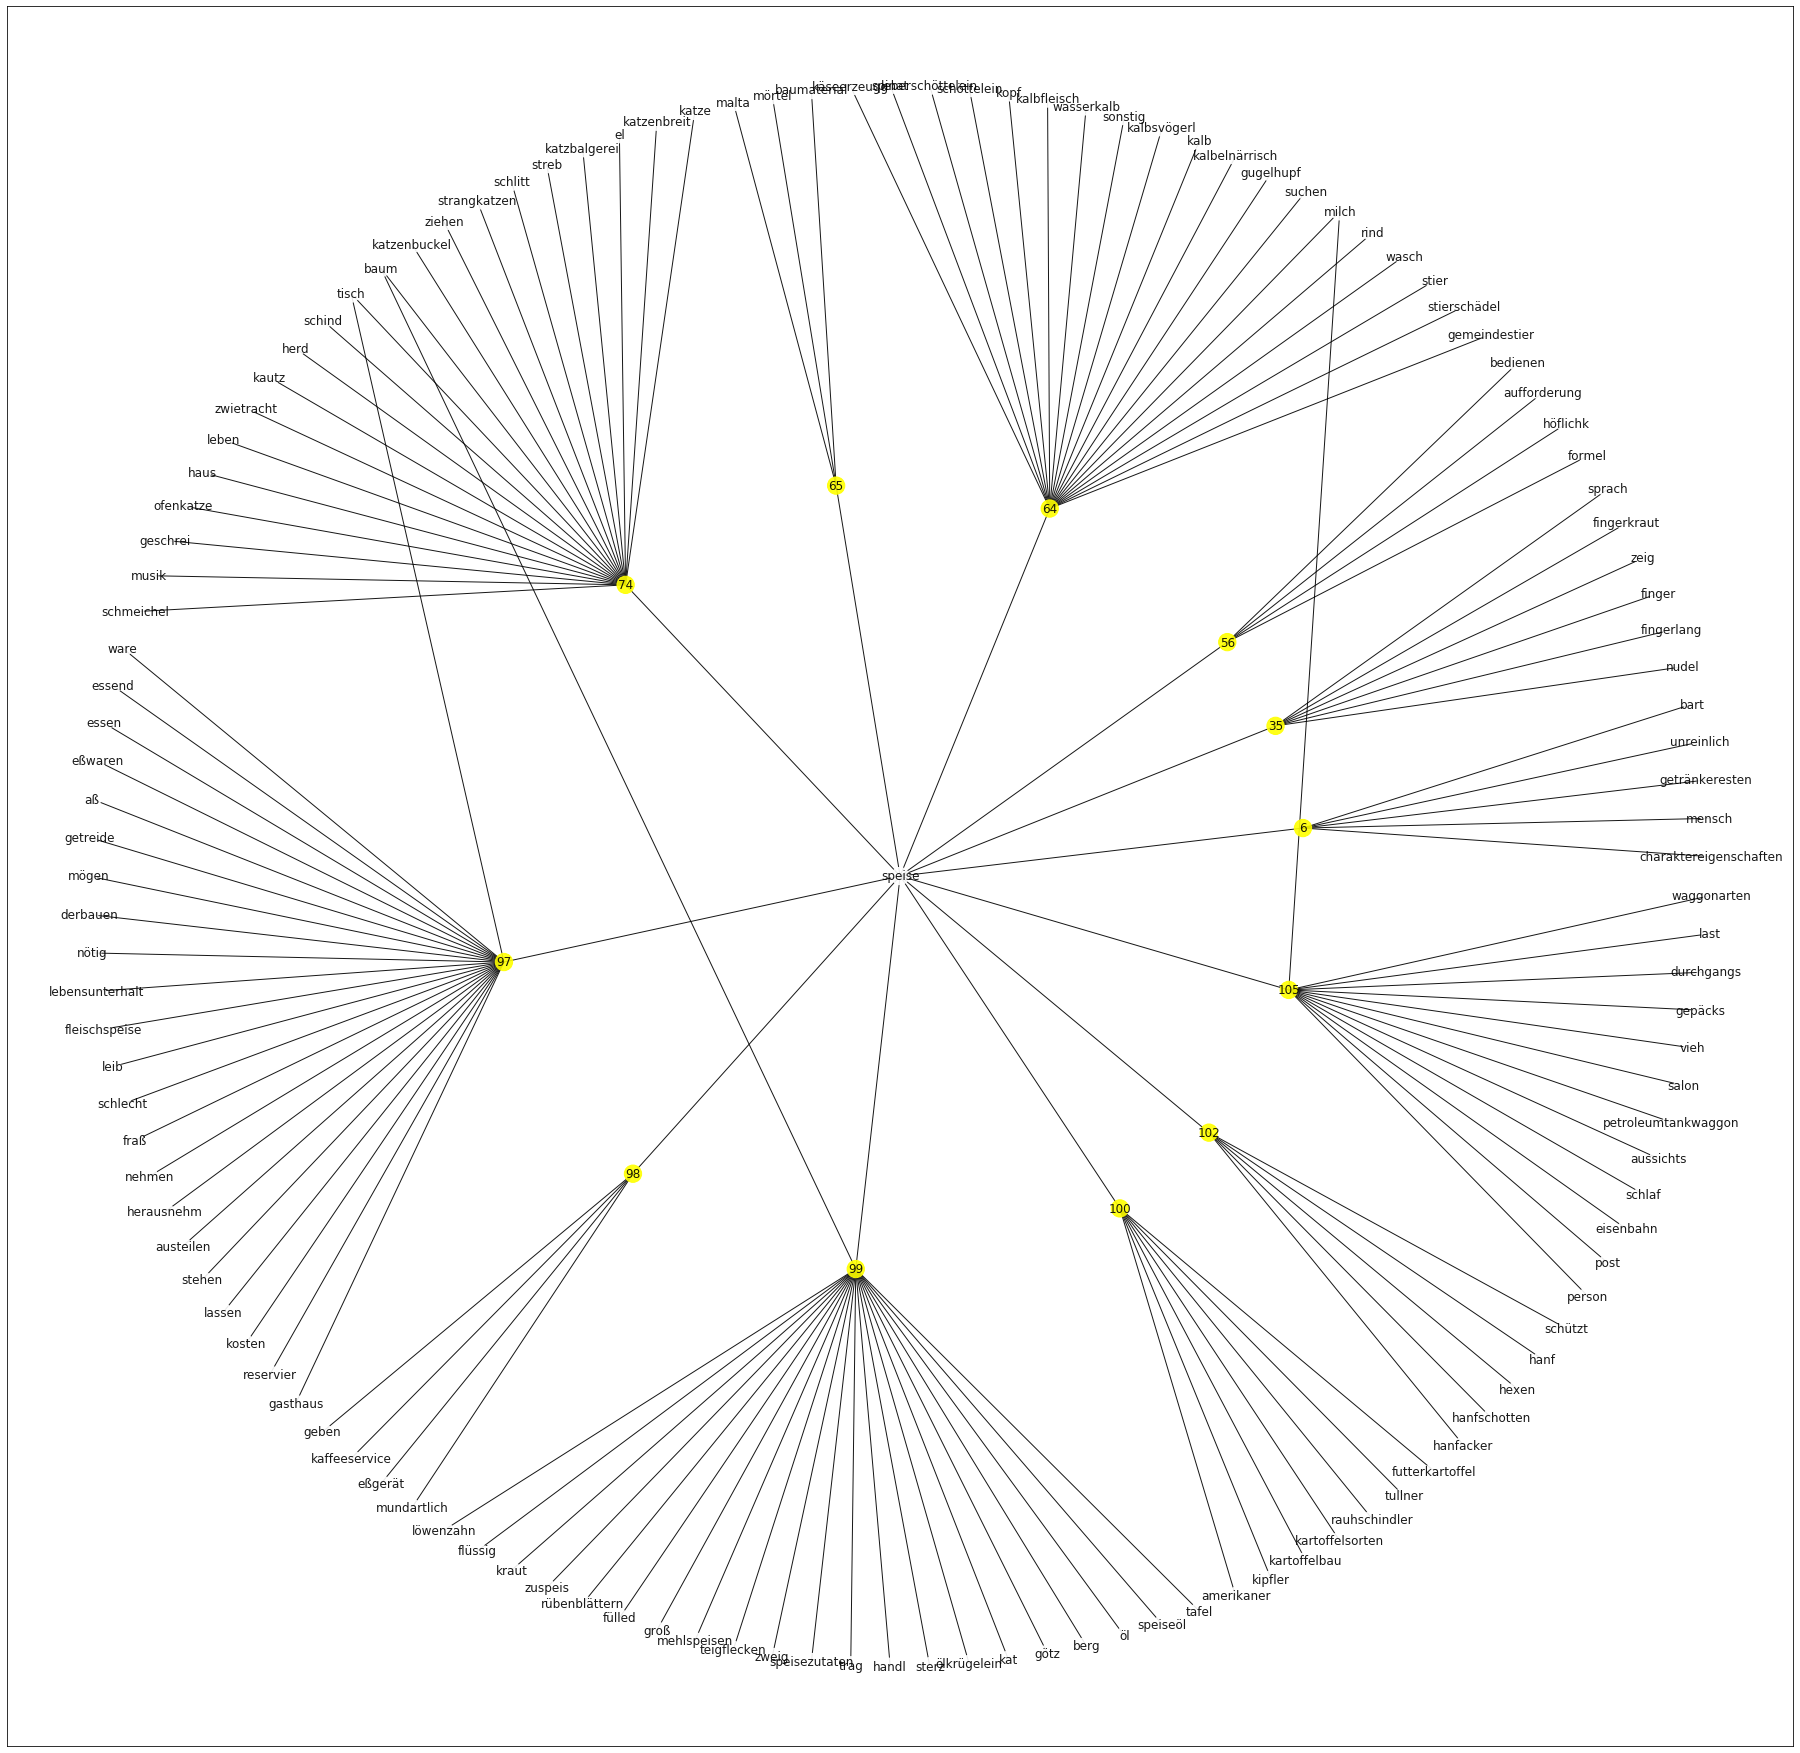

In [15]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 #cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )


#plt.show()


plt.savefig('./outputs/{}.png'.format(cfilter), bbox_inches='tight')

### Topic Modeling with the concepts

Preparing Document-Term Matrix

All the text documents combined is known as the corpus. To run any mathematical model on text corpus, it is a good practice to convert it into a matrix representation. LDA model looks for repeating term patterns in the entire DT matrix. Python provides many great libraries for text mining practices, “gensim” is one such clean and beautiful library to handle text data. It is scalable, robust and efficient. Following code shows how to convert a corpus into a document-term matrix.

In [16]:
all_concepts = []
for entry in frage.semantic_words.values:
    all_concepts.append(entry)
    
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(all_concepts)
#dictionary.filter_extremes(no_below=1, no_above=0.9)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_concepts]

Running LDA Model

Next step is to create an object for LDA model and train it on Document-Term matrix. The training also requires few parameters as input which are explained in the above section. The gensim module allows both LDA model estimation from a training corpus and inference of topic distribution on new, unseen documents.

In [17]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel
num_topics = 8

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=50)

In [18]:
ldamodel.print_topics(num_topics=num_topics, num_words=20)
#ldamodel.show_topics(10)

[(0,
  '0.012*"kopf" + 0.009*"schauen" + 0.008*"art" + 0.007*"fuß" + 0.006*"wasserbauten" + 0.006*"gasthaus" + 0.005*"sonstig" + 0.005*"hoch" + 0.005*"name" + 0.005*"besonderer" + 0.005*"eßgerät" + 0.005*"insekt" + 0.004*"trinken" + 0.004*"körperteil" + 0.004*"verschieden" + 0.004*"getreideernte" + 0.004*"geben" + 0.004*"ausdrücken" + 0.004*"schlafraum" + 0.004*"brust"'),
 (1,
  '0.014*"eisenbahn" + 0.010*"gewässer" + 0.009*"feld" + 0.008*"baum" + 0.008*"post" + 0.006*"bierbereitg" + 0.006*"wiese" + 0.006*"bier" + 0.005*"hand" + 0.005*"dreschen" + 0.005*"form" + 0.004*"wagen" + 0.004*"wein" + 0.004*"ganz" + 0.004*"wildtierleben" + 0.004*"alt" + 0.004*"wald" + 0.003*"zimmermann" + 0.003*"ähnlich" + 0.003*"schaf"'),
 (2,
  '0.012*"jagd" + 0.011*"bräuche" + 0.011*"bauer" + 0.008*"mehlspeisen" + 0.008*"brücke" + 0.007*"essen" + 0.007*"feuer" + 0.006*"zunftheiliger" + 0.006*"zunfttag" + 0.006*"gut" + 0.005*"schlecht" + 0.005*"weinbau" + 0.005*"schulunterricht" + 0.005*"wild" + 0.005*"lebens

In [19]:
topics_matrix = ldamodel.show_topics(formatted=False, num_words=20)
dic_topics = {num:words for num, words in topics_matrix}
df = pd.DataFrame(dic_topics)
df = df.reindex(sorted(df.columns), axis=1)
df.head(20)
#{num:words for num, words in topics_matrix}

0                              1  \
0            (kopf, 0.011587588)       (eisenbahn, 0.014135471)   
1        (schauen, 0.0086972015)        (gewässer, 0.010330289)   
2             (art, 0.007511929)            (feld, 0.009091511)   
3            (fuß, 0.0068576764)            (baum, 0.007851296)   
4   (wasserbauten, 0.0059118695)            (post, 0.007835385)   
5        (gasthaus, 0.005755157)    (bierbereitg, 0.0063440567)   
6         (sonstig, 0.005489499)           (wiese, 0.006067327)   
7           (hoch, 0.0052240756)           (bier, 0.0057561216)   
8            (name, 0.004835177)            (hand, 0.005029378)   
9      (besonderer, 0.004723644)        (dreschen, 0.004784833)   
10       (eßgerät, 0.0046642073)           (form, 0.0045733596)   
11        (insekt, 0.0046184375)           (wagen, 0.004154568)   
12       (trinken, 0.0044724722)            (wein, 0.003979555)   
13    (körperteil, 0.0043376964)           (ganz, 0.0039743655)   
14   (verschieden, 0.0042556776)  (wildtierleben, 0.0037091481)   
15   (getreideernte, 0.00411296)            (alt, 0.0036454184)   
16         (geben, 0.0040076133)           (wald, 0.0036260344)   
17    (ausdrücken, 0.0039354344)     (zimmermann, 0.0034214694)   
18    (schlafraum, 0.0039254203)        (ähnlich, 0.0033216372)   
19         (brust, 0.0037540183)          (schaf, 0.0032645033)   

                                 2                           3  \
0              (jagd, 0.011934157)        (gewerbe, 0.1222584)   
1           (bräuche, 0.011411713)        (mühle, 0.018215813)   
2             (bauer, 0.011187807)        (gehen, 0.009698605)   
3       (mehlspeisen, 0.008020456)       (gerät, 0.0075805313)   
4           (brücke, 0.0077503226)       (vogel, 0.0053422963)   
5            (essen, 0.0070407744)        (holz, 0.0053418013)   
6             (feuer, 0.006958118)         (fisch, 0.00459177)   
7      (zunftheiliger, 0.00633917)      (fahren, 0.0045029293)   
8           (zunfttag, 0.00633917)      (kommen, 0.0038361556)   
9              (gut, 0.0060838913)         (heu, 0.0038220498)   
10         (schlecht, 0.005360294)    (heuernte, 0.0033967665)   
11         (weinbau, 0.0052237664)     (schwein, 0.0032606584)   
12  (schulunterricht, 0.005215908)       (schiff, 0.003250569)   
13             (wild, 0.004890667)         (bau, 0.0029109605)   
14     (lebensalter, 0.0048499713)       (liebe, 0.0028307727)   
15            (haar, 0.0045261993)     (bringen, 0.0027961917)   
16             (kind, 0.004295231)    (bewegung, 0.0027838962)   
17           (hören, 0.0039875945)  (geistliche, 0.0027753576)   
18            (jung, 0.0039867796)      (stehen, 0.0027274543)   
19    (essensbereitg, 0.003853635)      (lassen, 0.0026648014)   

                               4                                5  \
0           (körper, 0.03749544)          (waldbaum, 0.014365188)   
1            (wild, 0.013178619)               (wer, 0.011203931)   
2           (rind, 0.0074855937)             (reden, 0.008186975)   
3            (haut, 0.007215112)       (volksglaube, 0.007990794)   
4       (wohnhaus, 0.0061283177)            (bauch, 0.0068287617)   
5      (erzeugnis, 0.0052889423)              (hals, 0.005520549)   
6         (pflanze, 0.004784953)         (bedeuten, 0.0052009406)   
7              (be, 0.004570944)               (rot, 0.004569942)   
8          (stelle, 0.004287818)    (wäschewaschen, 0.0041483575)   
9            (frau, 0.004212528)             (stein, 0.004138186)   
10  (leichenfeier, 0.0037414553)              (weiß, 0.003869559)   
11       (fleisch, 0.0036909657)             (groß, 0.0038439645)   
12     (begräbnis, 0.0036873952)        (käseerzeugg, 0.00379139)   
13        (kessel, 0.0035449855)              (tod, 0.0037218118)   
14        (zweiter, 0.003517624)           (geburt, 0.0037176667)   
15         (führen, 0.003420339)  (rindfleischsorte, 0.003658895)   
16          (wind, 0.0033112376)          (schwarz, 0.003509012

In [20]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)
pyLDAvis.save_html(p, './outputs/lda.html')

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


### Using Word Embeddings

In [21]:
import gensim
from gensim import corpora
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.word2vec import LineSentence
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

#### [trained model 1](https://devmount.github.io/GermanWordEmbeddings/#download)  

In [22]:
# get trained model, files without a suffix, .bin or .model are treated as binary files
trained_model1 = gensim.models.KeyedVectors.load_word2vec_format('../../nlp/German_Word2vec/german.model', binary=True)
# remove original vectors to free up memory
trained_model1.init_sims(replace=True)

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Different [metrics](http://mkusner.github.io/publications/WMD.pdf)

In [23]:
print(trained_model1.similarity('kopf', 'blau'))
print(trained_model1.distance('kopf', 'blau'))

0.4494617
0.5505383014678955


In [24]:
words = ['blau', 'rot', 'kopf', 'Gewerbe']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in trained_model1.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('rot', 0.8281903862953186)
('gruen', 0.7959476709365845)
('gelb', 0.7838804721832275)
('orange', 0.7746740579605103)
('grau', 0.7626761198043823)
('Blau', 0.7593175172805786)
('schwarz', 0.755070149898529)
('braun', 0.7448124885559082)
('tuerkis', 0.7368776202201843)
('rosa', 0.7332463264465332)
('lila', 0.7257266640663147)
('rot_gelb', 0.7144009470939636)
('Hellblau', 0.7142020463943481)
('gelb_blau', 0.7131950855255127)
('blau_rot', 0.7092214822769165)
('dunkelblau', 0.707565188407898)
('Gelb_Orange', 0.7064606547355652)
('pink', 0.7047414779663086)
('weiss_rot', 0.7010555267333984)
('rot_blau', 0.6987532377243042)

word: rot
('gelb', 0.8350189924240112)
('gruen', 0.8290626406669617)
('blau', 0.8281903266906738)
('schwarz', 0.7826082706451416)
('orange', 0.7713059186935425)
('grau', 0.7314903736114502)
('rot_gelb', 0.7234443426132202)
('rote', 0.7225121259689331)
('braun', 0.7214125990867615)
('lila', 0.7197442650794983)
('violett', 0.7078529596328735)
('Blau', 0.7019246

In [25]:
list_words = ['blau', 'rot', 'feld', 'grün', 'gelb']
print(trained_model1.doesnt_match(list_words))

feld


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [26]:
for result in trained_model1.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('rosa', 0.6545881032943726)
('orange', 0.6302927732467651)
('gruen', 0.619945764541626)
('rot', 0.619027316570282)
('Glitzer', 0.6155712604522705)
('lila', 0.6148803234100342)
('grau', 0.6142277717590332)
('pink', 0.6076772212982178)
('knallrot', 0.6024129390716553)
('knallige_Farben', 0.5976543426513672)


In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# function draw_words
# ... reduces dimensionality of vectors of given words either with PCA or with t-SNE and draws the words into a diagram
# @param word2vec model     to visualize vectors from
# @param list     words     list of word strings to visualize
# @param bool     pca       use PCA (True) or t-SNE (False) to reduce dimensionality 
# @param bool     alternate use different color and label align for every second word
# @param bool     arrows    use arrows to connect related words (items that are next to each other in list)
# @param float    x1        x axis range (from)
# @param float    x2        x axis range (to)
# @param float    y1        y axis range (from)
# @param float    y2        y axis range (to)
# @param string   title     for diagram

def draw_words(model, words, pca=False, alternate=True, arrows=True, x1=3, x2=3, y1=3, y2=3, title=''):
    # get vectors for given words from model
    vectors = [model[word] for word in words]
    if pca:
        pca = PCA(n_components=2, whiten=True)
        vectors2d = pca.fit(vectors).transform(vectors)
    else:
        tsne = TSNE(n_components=2, random_state=0)
        vectors2d = tsne.fit_transform(vectors)

    # draw image
    plt.figure(figsize=(6,6))
    if pca:
        plt.axis([x1, x2, y1, y2])

    first = True # color alternation to divide given groups
    for point, word in zip(vectors2d , words):
        # plot points
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        # plot word annotations
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "x-large"
        )
        first = not first if alternate else first

    # draw arrows
    if arrows:
        for i in range(0, len(words)-1, 2):
            a = vectors2d[i][0] + 0.04
            b = vectors2d[i][1]
            c = vectors2d[i+1][0] - 0.04
            d = vectors2d[i+1][1]
            plt.arrow(a, b, c-a, d-b,
                shape='full',
                lw=0.1,
                edgecolor='#bbbbbb',
                facecolor='#bbbbbb',
                length_includes_head=True,
                head_width=0.08,
                width=0.01
            )

    # draw diagram title
    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

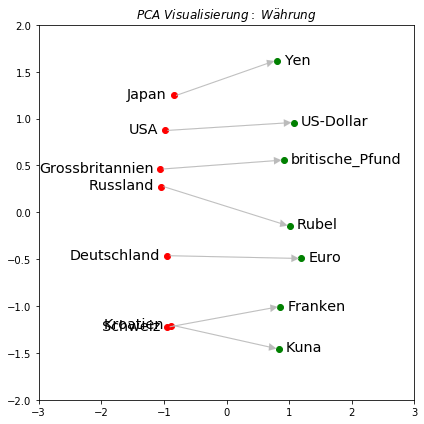

In [28]:
# plot currencies
words = ["Schweiz",
         "Franken",
         "Deutschland",
         "Euro",
         "Grossbritannien",
         "britische_Pfund",
         "Japan",
         "Yen",
         "Russland",
         "Rubel",
         "USA",
         "US-Dollar",
         "Kroatien",
         "Kuna"]

draw_words(trained_model1, words, True, True, True, -3, 3, -2, 2, r'$PCA\ Visualisierung:\ W\ddot{a}hrung$')

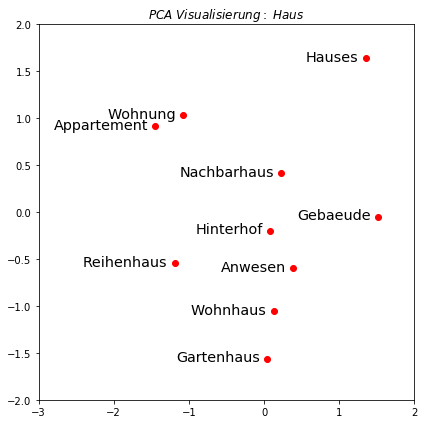

In [29]:
# plot related words to 'house'
matches = trained_model1.most_similar(positive=["Haus"], negative=[], topn=10)
words = [match[0] for match in matches]
draw_words(trained_model1, words, True, False, False, -3, 2, -2, 2, r'$PCA\ Visualisierung:\ Haus$')

#### [trained model 2](https://deepset.ai/german-word-embeddings)

In [30]:
w2v_file = '../../nlp/Deepset_models/w2v/W2V_vectors2.txt'
trained_model2 = KeyedVectors.load_word2vec_format(w2v_file, binary=False, encoding="utf-8")

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [31]:
trained_model2.vectors.shape

(854776, 300)

In [32]:
print(trained_model2.similarity('kopf', 'blau'))
print(trained_model2.distance('kopf', 'blau'))

0.31584507
0.6841549277305603


In [33]:
words = ['blau', 'rot', 'kopf', 'gewerbe']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in trained_model2.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('rot', 0.8878530859947205)
('grün', 0.8801577687263489)
('gelb', 0.8124666213989258)
('schwarz', 0.7995022535324097)
('weiß', 0.7513998746871948)
('violett', 0.7186183333396912)
('dunkelblau', 0.7036298513412476)
('farben', 0.6818685531616211)
('silbern', 0.6753426194190979)
('blauen', 0.6669750213623047)
('grau', 0.6544827222824097)
('blauer', 0.652576744556427)
('gestreift', 0.6439394354820251)
('lila', 0.6385097503662109)
('dunkelrot', 0.6316858530044556)
('hellblau', 0.6249961853027344)
('schild', 0.6212359070777893)
('beige', 0.6211506724357605)
('türkis', 0.61705482006073)
('blaue', 0.6129087209701538)

word: rot
('blau', 0.8878530263900757)
('grün', 0.8219360709190369)
('gelb', 0.8039773106575012)
('schwarz', 0.7836544513702393)
('weiß', 0.7218809127807617)
('violett', 0.6870977282524109)
('dunkelblau', 0.6600711345672607)
('silbern', 0.6583701968193054)
('farben', 0.64675372838974)
('blauen', 0.642576277256012)
('grau', 0.636203408241272)
('blauer', 0.6272552013397

In [34]:
list_words = ['blau', 'rot', 'feld', 'grün', 'gelb']
print(trained_model2.doesnt_match(list_words))

feld


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/gensim/models/keyedvectors.py:876: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [35]:
for result in trained_model2.most_similar(positive=['frau', 'blau'], negative=['mann']):
    print(result)

('rot', 0.6391851305961609)
('grün', 0.6378831267356873)
('gelb', 0.6027040481567383)
('schwarz', 0.5865936279296875)
('lila', 0.5341690182685852)
('weiß', 0.5315088629722595)
('violett', 0.5308850407600403)
('blauen', 0.5186036229133606)
('blaue', 0.4993555545806885)
('silbern', 0.4934939742088318)


### Training our own model

In [36]:
sentences = []
for sentence in frage.semantic_words.values:
    sentences.append(sentence)

our_model = gensim.models.Word2Vec(sentences, min_count=1)

In [37]:
words = ['blau', 'rot', 'kopf']
for word in words:
    print()
    print('word: {}'.format(word))
    for result in our_model.wv.most_similar(word, topn=20):
        print(result)
        #print("{}: {:.8f}".format(*result))


word: blau
('beziehen', 0.5580719709396362)
('reden', 0.5530161261558533)
('sonstig', 0.5521533489227295)
('baum', 0.5369779467582703)
('ähnlich', 0.5338228940963745)
('haut', 0.5275418758392334)
('art', 0.5274667739868164)
('weit', 0.5233060121536255)
('hand', 0.5180236101150513)
('haus', 0.5173885822296143)
('besonderer', 0.516680121421814)
('kind', 0.5153724551200867)
('wer', 0.5149707794189453)
('klein', 0.5118941068649292)
('gut', 0.511823296546936)
('be', 0.5116266012191772)
('bedeuten', 0.5091391801834106)
('brotteig', 0.5080698132514954)
('stoß', 0.5079566240310669)
('liegen', 0.5071793794631958)

word: rot
('besonderer', 0.7847210168838501)
('ähnlich', 0.7615989446640015)
('name', 0.753455400466919)
('dergleichen', 0.753184974193573)
('wer', 0.7501528263092041)
('vogel', 0.7500501871109009)
('gewerbe', 0.7489913702011108)
('form', 0.7474057078361511)
('kommen', 0.7471129298210144)
('lassen', 0.7461913824081421)
('geschlecht', 0.7460800409317017)
('verwendung', 0.7444720268249

In [38]:
# saving the model
our_model.wv.save_word2vec_format('./nlp/our_model.bin', binary=True)

#### Expanding a graph with similar words

In [39]:
#cfilter = "kopf"
#cfilter = "schwarz"
cfilter = "suppe"
#cfilter = "speise"
filtered = frage[frage.semantic_words.apply(lambda x: cfilter in x)]

In [41]:
G = nx.Graph()

for concept_list in filtered.semantic_words:
    for concept in concept_list:
        G.add_node(concept, color='white')
        for w in our_model.wv.most_similar(concept, topn=5):
            G.add_node(w[0], color='white')
            G.add_edge(concept, w[0], length = 10)        
        
for questionnaire in filtered.fragebogen_id:
    G.add_node(questionnaire, color='yellow')
    
for idn in filtered.index:
    for concept in filtered.loc[idn, 'semantic_words']:
        G.add_edge(concept, filtered.loc[idn, 'fragebogen_id'], length = 10)

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


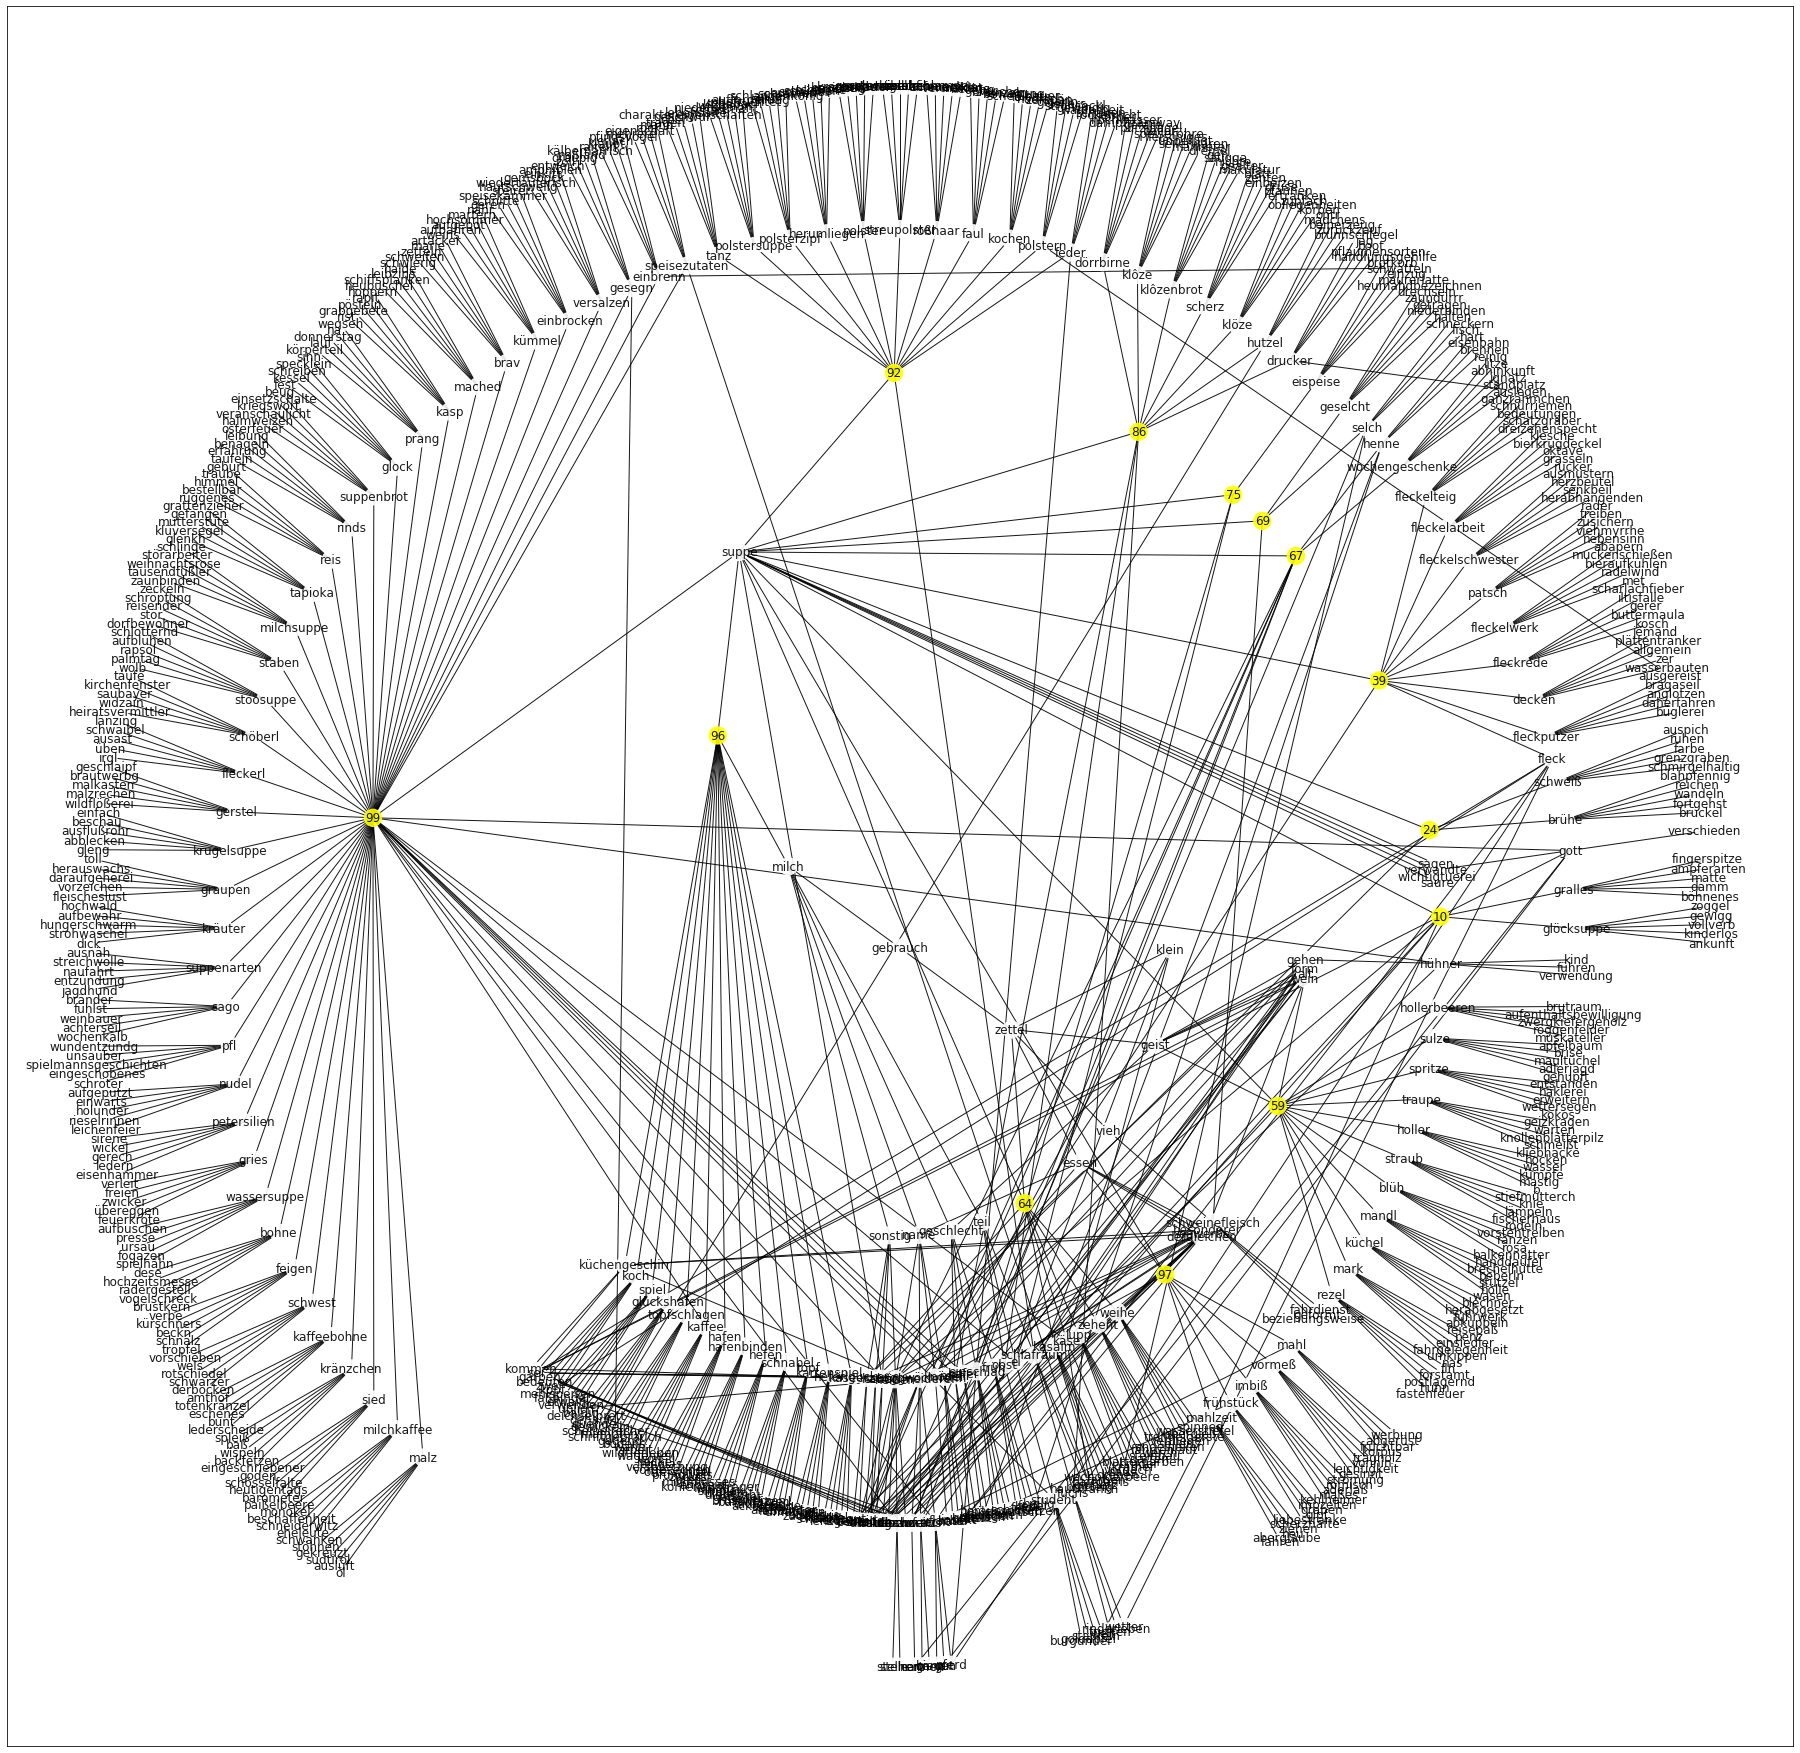

In [42]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(G)
#pos = graphviz_layout(G)
pos = graphviz_layout(G, prog='twopi', args='')


nx.draw_networkx(G, 
                 pos,
                 width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(G,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

#plt.show()

plt.savefig('./outputs/{}_plus_similar.png'.format(cfilter), bbox_inches='tight')

### Using [Patern.de](https://www.clips.uantwerpen.be/pages/pattern-de)

In [43]:
import pattern.de as pde

In [44]:
print(pde.gender('Katze'))
print(pde.article('Katze', pde.DEFINITE, gender=pde.FEMALE, role=pde.OBJECT))
print(pde.singularize('Katzen'))
print(pde.pluralize('Katze'))
print(pde.conjugate('war', pde.INFINITIVE))
print(pde.conjugate('war', pde.PRESENT, 1, pde.SG, mood=pde.SUBJUNCTIVE))
print(pde.predicative('neugierige')) 
print(pde.attributive('neugierig', gender=pde.FEMALE))
print(pde.attributive('neugierig', gender=pde.FEMALE, role=pde.OBJECT))
print(pde.attributive('neugierig', gender=pde.FEMALE, role=pde.INDIRECT, article="die"))

f
die
Katze
Katzen
sein
sei
neugierig
neugierige
neugierige
neugierigen


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/pattern/text/__init__.py:2127: DeprecationWarning: generator '_read' raised StopIteration
  for v in _read(self._path):


In [45]:
s = pde.parse('Die böse Katze liegt auf der Matte.', tagset="STTS")
for sentence in s.split():
    print(sentence)

[['Die', 'ARTDEF', 'O', 'O'], ['böse', 'ADJA', 'O', 'O'], ['Katze', 'NN', 'B-NP', 'O'], ['liegt', 'VVFIN', 'B-PP', 'B-PNP'], ['auf', 'APPR', 'B-NP', 'I-PNP'], ['der', 'ARTDEF', 'O', 'O'], ['Matte', 'NN', 'B-NP', 'O'], ['.', 'S', 'O', 'O']]


/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/pattern/text/__init__.py:625: DeprecationWarning: generator '_read' raised StopIteration
  dict.update(self, (x.split(" ")[:2] for x in _read(self._path) if len(x.split(" ")) > 1))
/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/pattern/text/__init__.py:868: DeprecationWarning: generator '_read' raised StopIteration
  list.extend(self, (x.split() for x in _read(self._path)))


In [46]:
s = pde.parse('Die böse Katze liegt auf der weichen Matte.')
for sentence in s.split():
    print(sentence)

[['Die', 'DT', 'B-NP', 'O'], ['böse', 'JJ', 'I-NP', 'O'], ['Katze', 'NN', 'I-NP', 'O'], ['liegt', 'VB', 'B-VP', 'O'], ['auf', 'IN', 'B-PP', 'B-PNP'], ['der', 'DT', 'B-NP', 'I-PNP'], ['weichen', 'PRP$', 'I-NP', 'I-PNP'], ['Matte', 'NN', 'I-NP', 'I-PNP'], ['.', '.', 'O', 'O']]


Dividing the concepts by gramatical classes

In [47]:
def onlynouns(l):
    nouns = [w for w in l if pde.parse(w).split('/')[1] == 'NN']
    return(nouns)

def onlyverbs(l):
    verbs = [w for w in l if pde.parse(w).split('/')[1] == 'VB']
    return(verbs)

def onlyadject(l):
    adjects = [w for w in l if pde.parse(w).split('/')[1] == 'JJ']
    return(adjects)

In [48]:
frage_POS = pd.concat([frage.semantic_words.apply(onlynouns),
                       frage.semantic_words.apply(onlyverbs),
                       frage.semantic_words.apply(onlyadject)], axis=1)

frage_POS.columns = ['NN','VB', 'ADJ']
frage_POS.head(30)

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/pattern/text/__init__.py:772: DeprecationWarning: generator '_read' raised StopIteration
  list.extend(self, (x.split() for x in _read(self._path)))


NN  \
0                                              [kopf]   
1                      [zerspringen, vergleich, kopf]   
2                        [vergleich, verdrehen, kopf]   
3                     [tituskopf, christuskopf, kopf]   
4                                              [kopf]   
5                                              [kopf]   
6                                  [wasserkopf, kopf]   
7                                              [kopf]   
8                                  [zugespitzt, kopf]   
9                                              [kopf]   
10                                             [kopf]   
11                                             [kopf]   
12                                             [kopf]   
13                                             [kopf]   
14                                             [kopf]   
15   [haar, krausem, mohrenkopf, gesichtsfarbe, kopf]   
16  [fischkopf, aufgezogen, nase, kindskopf, hasen...   
17       [laus, nißkopf, behafteen, ungeziefer, kopf]   
18         [typhus, krankheit, kopfweh, kopfes, kopf]   
19   [krankheit, grindkopf, krätzen, entstellt, kopf]   
20                            [beule, auswuchs, kopf]   
21                           [schädeln, schlag, kopf]   
22                                             [kopf]   
23                        [weiberkopf, schädel, kopf]   
24                         [kopfstück, schädel, kopf]   
25                                        [totenkopf]   
26              [totenkopf, wiedereingraben, bräuche]   
27              [nachbildung, totenkopf, totenkopfes]   
28                            [aberglaube, totenkopf]   
29  [platte, kästlein, hirnschale, schädeldecke, k...   

                                                   VB                     ADJ  
0                                                  []                      []  
1                                   [möchten, stehen]          [ursprünglich]  
2                                                  []           [fein, offen]  
3                                                  []      [schön, ebenmäßig]  
4                                                  []  [unebenmäßig, häßlich]  
5                                                  []      [groß, großkopfig]  
6                                                  []                      []  
7                                                  []                 [klein]  
8                                                  []                      []  
9                                                  []                  [lang]  
10                                                 []           [platt, kurz]  
11                                                 []                      []  
12                                                 []                 [breit]  
13                                                 []              [schmaler]  
14                                                 []                [schief]  
15                                                 []                [dunkel]  
16                                                 []            [fischartig]  
17                                                 []                      []  
18                                                 []                      []  
19                                                 []                      []  
20                                                 []                      []  
21                                         [schlagen]                      []  
22                                                 []                      []  
23                                                 []               [sonstig]  
24                                                 []               [sonstig]  
25                                                 []                      []  
26  [waschen, beziehen, färben, hinterlegen, einwi...                      []  
27                                         

### Using [Spacy](https://spacy.io/)

In [49]:
import spacy

In [50]:
# https://spacy.io/models
nlp = spacy.load("de_core_news_sm")
#nlp = spacy.load("de_core_news_md")

In [51]:
for l in frage.semantic_words.values[0:5]:
    for w in l:
        doc = nlp(w)
        for token in doc:
            print(token.text, 
                  token.lemma_, 
                  token.pos_, 
                  token.tag_, 
                  token.dep_,
                  token.shape_, 
                  token.is_alpha, 
                  token.is_stop)
    print()

haupt haupt ADJ ADJD ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True False

zerspringen zerspringen VERB VVINF ROOT xxxx True False
ursprünglich ursprünglich ADJ ADJD ROOT xxxx True False
möchten mögen VERB VMFIN ROOT xxxx True False
stehen stehen VERB VVINF ROOT xxxx True False
vergleich vergleich ADJ ADJD ROOT xxxx True False
haupt haupt ADJ ADJD ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True False

vergleich vergleich ADJ ADJD ROOT xxxx True False
verdrehen verdrehen VERB VVINF ROOT xxxx True False
fein fein ADJ ADJD ROOT xxxx True False
offen offen ADJ ADJD ROOT xxxx True True
jemand jemand PRON PIS ROOT xxxx True True
haupt haupt ADJ ADJD ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True False

tituskopf tituskopf ADJ ADJD ROOT xxxx True False
schön schön ADJ ADJD ROOT xxxx True False
gebaut bauen VERB VVPP ROOT xxxx True False
christuskopf christuskopf X XY ROOT xxxx True False
ebenmäßig ebenmäßig ADJ ADJD ROOT xxxx True False
kopf kopf ADJ ADJD ROOT xxxx True

### Using [PyGermanet](https://pypi.org/project/pygermanet/)

In [55]:
#https://nlpforhackers.io/starting-wordnet/

from pygermanet import load_germanet, Synset
from scipy.stats.stats import pearsonr

In [56]:
from pygermanet import load_germanet
gn = load_germanet()

In [58]:
#word = 'Suppe'
#word = 'falb'
word = 'Kopf'

lem = gn.lemmatise(word)[0]
print("concept: {}, lemma: {} ".format(word, lem))
print()
syn = gn.synsets(lem)
if not syn:
    syn = gn.synsets(lem.title()) #[0]
else:
    syn = gn.synsets(lem) #[0]
for s in syn:
    print("synset: ", s)
    print()
    for lemma in s.lemmas:
        print('\t- {}'.format(lemma.orthForm))
    print()    
    for hypo in s.hyponyms:
        print('\thyponym: {}'.format(hypo))
    print()
    for hyper in s.hypernyms:
        print('\thypernym: {}'.format(hyper))
        print()
    print('\tgeneric class: {}'.format(s.gn_class))
    print()
print()

concept: Kopf, lemma: Kopf 

synset:  Synset(Birne.n.1)

	- Birne
	- Schädel
	- Kopf
	- Haupt
	- Rübe

	hyponym: Synset(Menschenkopf.n.1)
	hyponym: Synset(Grind.n.3)
	hyponym: Synset(Männerkopf.n.1)
	hyponym: Synset(Tierkopf.n.1)
	hyponym: Synset(Krauskopf.n.1)
	hyponym: Synset(Engelskopf.n.1)
	hyponym: Synset(Köpfchen.n.1)
	hyponym: Synset(Charakterkopf.n.1)

	hypernym: Synset(Körperteil.n.1)

	generic class: Koerper

synset:  Synset(Kopf.n.2)

	- Kopf


	hypernym: Synset(Einzelindividuum.n.1)

	generic class: Mensch

synset:  Synset(Kopf.n.3)

	- Kopf
	- Anfangsteil


	hypernym: Synset(Bestandteil.n.1)

	generic class: Artefakt

synset:  Synset(Kopf.n.4)

	- Kopf


	hypernym: Synset(Silbenteil.n.1)

	generic class: Kommunikation

synset:  Synset(Kopf.n.6)

	- Kopf


	hypernym: Synset(nichtdefinite Längeneinheit.n.1)

	generic class: Menge

synset:  Synset(Kopf.n.7)

	- Kopf
	- Haupt

	hyponym: Synset(Hauptperson.n.1)
	hyponym: Synset(Familienhaupt.n.1)
	hyponym: Synset(Oberhaupt.n.1)

In [59]:
G = nx.Graph()

for concept_list in frage.semantic_words:
    for concept in concept_list:
        lem = gn.lemmatise(concept)[0]
        #print("concept: {}, lemma: {} ".format(concept, lem))
        G.add_node(lem, color='white', label='concept')
        syn = gn.synsets(lem)
        if not syn:
            syn = gn.synsets(lem.title()) #[0]
        else:
            syn = gn.synsets(lem) #[0]
        #print("synsets: ", syn)
        for s in syn:
            #print("synset lemmas: ", s.lemmas)
            #print("synset hyponims: ", s.hyponyms)
            #print("synset hypernyms: ", s.hypernyms)
            #print("synset entails: ", s.entails)
            #print("synset gen. class: ", s.gn_class)
            G.add_node(s.gn_class, color='yellow', label='gn_class')
            G.add_edge(lem, s.gn_class, length = 10)
            #print("synset max depth: ", s.max_depth)

In [63]:
nodes_gclasses = [x for x,y in G.nodes(data=True) if y['label']=='gn_class']
nodes_gclasses

['Koerper',
 'Mensch',
 'Artefakt',
 'Kommunikation',
 'Menge',
 'Relation',
 'Veraenderung',
 'Zeit',
 'Allgemein',
 'Gefuehl',
 'Gesellschaft',
 'Lokation',
 'Besitz',
 'Kognition',
 'Konkurrenz',
 'Schoepfung',
 'Substanz',
 'Verhalten',
 'privativ',
 'Ort',
 'Kontakt',
 'Verbrauch',
 'natPhaenomen',
 'Koerperfunktion',
 'Perzeption',
 'Nahrung',
 'Attribut',
 'Pflanze',
 'Tier',
 'Geschehen',
 'Gruppe',
 'Form',
 'Bewegung',
 'Geist',
 'Pertonym',
 'natGegenstand',
 'Tops',
 'Motiv']

In [65]:
#https://stackoverflow.com/questions/45350222/select-nodes-and-edges-form-networkx-graph-with-attributes
word = 'Ort'
neighbors = list(nx.neighbors(G,word))
neighbors.append(word)
Gfilter = G.subgraph(neighbors)
len(Gfilter)

581

/home/rsouza/Documents/envs/python_env/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


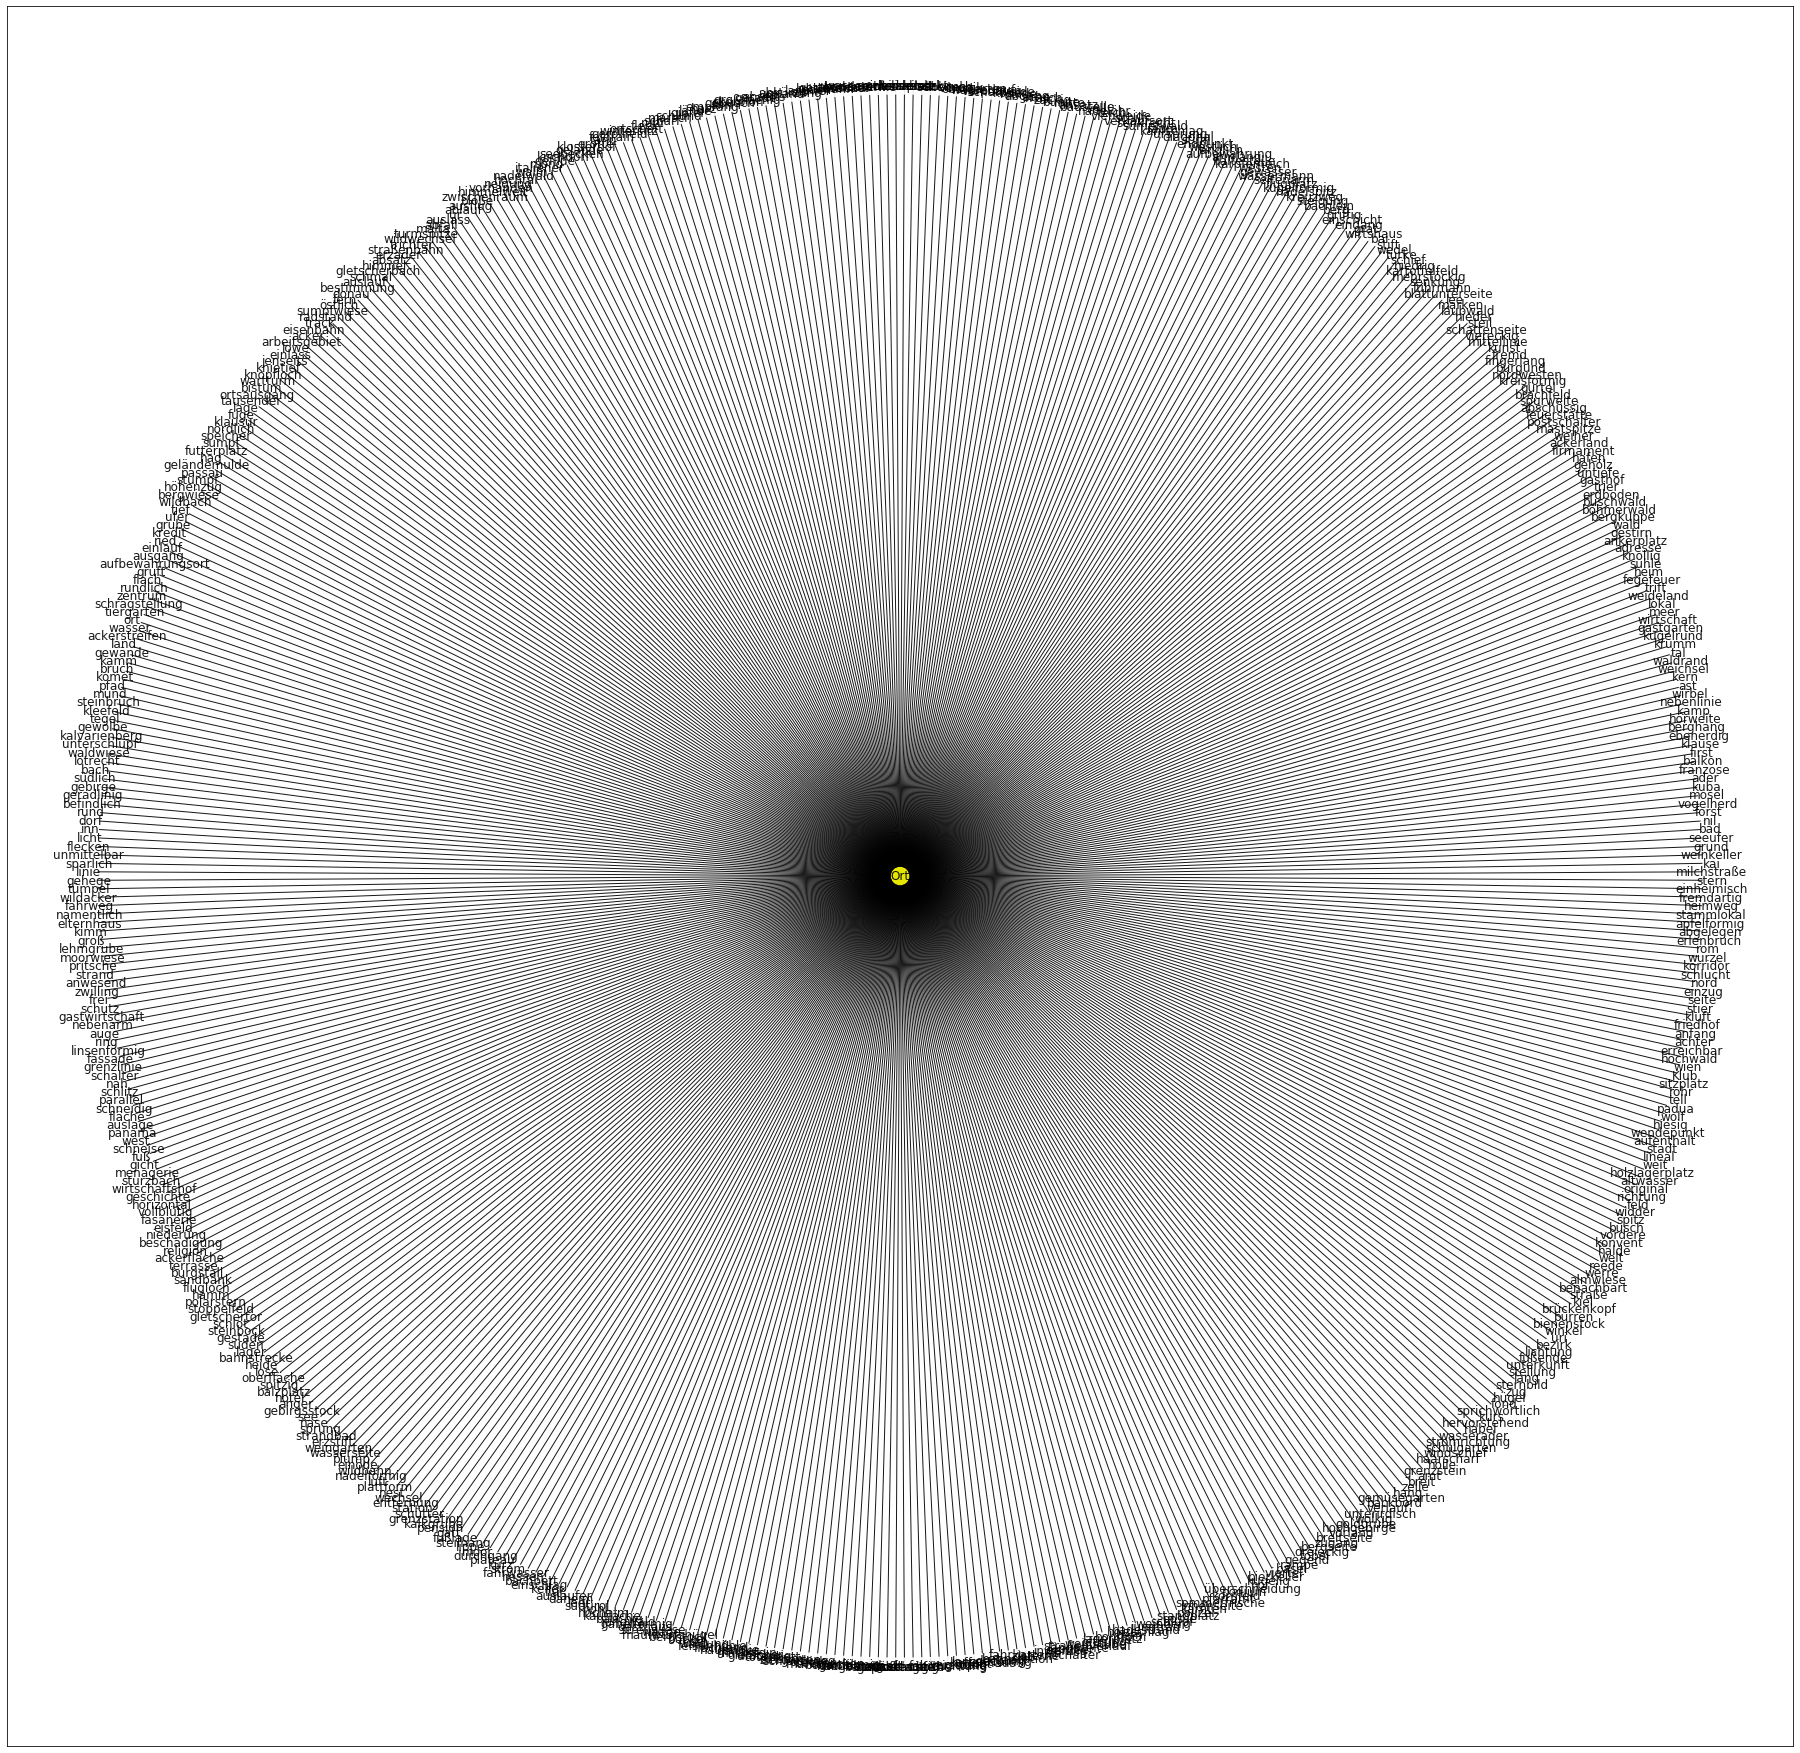

In [66]:
plt.figure(figsize=(32,32))

#pos = nx.spring_layout(Gfilter)
#pos = graphviz_layout(Gfilter)
pos = graphviz_layout(Gfilter, prog='twopi', args='')


nx.draw_networkx(Gfilter, 
                 pos,
                 width=1,
                 alpha=0.9,
                 cmap=plt.get_cmap('viridis'),
                 node_color=nx.get_node_attributes(Gfilter,'color').values(), 
                 with_labels=True,
                 #font_weight='bold', 
                 #font_color='white',
                 )

#plt.show()

plt.savefig('./outputs/{}_germanet.png'.format(word), bbox_inches='tight')

### Using [Watson Python API](https://github.com/watson-developer-cloud/python-sdk) 